# Six Nations 2018 prediction

The goal of this analysis will be to predict team scores for a given fixture.

## Data Collection

Data taken from stats.espnscrum.com/statsguru. We will start by looking only at team data from the last 4 years(2014-2018) for six nations teams. Once we have a model up and running, we may look at using additional data. 

We first define a base url from the url of a desirable query result. Here we have to iterate through the desired teams.

In [180]:
base_url = 'http://stats.espnscrum.com/statsguru/rugby/stats/index.html?class=1;orderby=date;orderbyad=reverse;spanmax2=31+Jan+2019;spanmin2=31+Jan+2014;spanval2=span;team={};template=results;type=team;view=match'

Data of interest appeared to be stored in the third table of the page.

In [181]:
import urllib.request
import pandas as pd
from bs4 import BeautifulSoup

class HTMLTableParser:

    def parse_url(self, url):
        with urllib.request.urlopen(url) as response:
            page = response.read()
        soup = BeautifulSoup(page, 'lxml')
        #Rugby data on table 3
        return self.parse_html_table(soup.find_all('table')[3])

    def parse_html_table(self, table):
        n_columns = 0
        n_rows=0
        column_names = []

        # Find number of rows and columns
        # we also find the column titles if we can
        for row in table.find_all('tr'):

            # Determine the number of rows in the table
            td_tags = row.find_all('td')
            if len(td_tags) > 0:
                n_rows+=1
                if n_columns == 0:
                    # Set the number of columns for our table
                    n_columns = len(td_tags)

            # Handle column names if we find them
            th_tags = row.find_all('th') 
            if len(th_tags) > 0 and len(column_names) == 0:
                for th in th_tags:
                    column_names.append(th.get_text())

        # Safeguard on Column Titles
        if len(column_names) > 0 and len(column_names) != n_columns:
            raise Exception("Column titles do not match the number of columns")

        columns = column_names if len(column_names) > 0 else range(0,n_columns)
        df = pd.DataFrame(columns = columns,
                          index= range(0,n_rows))
        row_marker = 0
        for row in table.find_all('tr'):
            column_marker = 0
            columns = row.find_all('td')
            for column in columns:
                df.iloc[row_marker,column_marker] = column.get_text()
                column_marker += 1
            if len(columns) > 0:
                row_marker += 1

        # Convert to float if possible
        for col in df:
            try:
                df[col] = df[col].astype(float)
            except ValueError:
                pass

        return df

In [182]:
hp = HTMLTableParser()

team_ids = (1,2,3,4,9,20)

#Iterate through team ids and store in a pandas table
tables = []
for team in team_ids:
    table = hp.parse_url(base_url.format(team)) # Grabbing the table from the tuple
    print(type(table))
    tables.append(table)


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


Store data to prevent having to requery the site

In [183]:
raw_data = pd.concat(tables)


In [184]:
print(raw_data.head())

      Team Result   For   Aga  Diff Tries Conv Pens Drop     Opposition  \
0  England    won  46.0  15.0  31.0     7    4    1    0        v Italy   
1  England    won  48.0  14.0  34.0     7    5    1    0        v Samoa   
2  England    won  30.0   6.0  24.0     4    2    2    0    v Australia   
3  England    won  21.0   8.0  13.0     2    1    3    0    v Argentina   
4  England    won  35.0  25.0  10.0     4    3    2    1    v Argentina   

       Ground   Match Date    
0        Rome   4 Feb 2018    
1  Twickenham  25 Nov 2017    
2  Twickenham  18 Nov 2017    
3  Twickenham  11 Nov 2017    
4    Santa Fe  17 Jun 2017    


## Exploratory data analysis

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler 

%matplotlib inline

plt.style.use('bmh')

In [186]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290 entries, 0 to 47
Data columns (total 14 columns):
Team          290 non-null object
Result        290 non-null object
For           290 non-null float64
Aga           290 non-null float64
Diff          290 non-null float64
Tries         290 non-null object
Conv          290 non-null object
Pens          290 non-null object
Drop          290 non-null object
              290 non-null object
Opposition    290 non-null object
Ground        290 non-null object
Match Date    290 non-null object
              290 non-null object
dtypes: float64(3), object(11)
memory usage: 34.0+ KB


With the exception of two null columns that have been created, it appears we have full data for all other fields


In [187]:
#Dropping null columns
cols = [9,13]
raw_data = raw_data.drop(raw_data.columns[cols],axis=1)

raw_data.to_csv('raw_data.csv')


In [188]:
raw_data = pd.read_csv('raw_data.csv', index_col=0)
raw_data.head()

Team Result   For   Aga  Diff Tries Conv Pens Drop   Opposition  \
0  England    won  46.0  15.0  31.0   7.0  4.0  1.0  0.0      v Italy   
1  England    won  48.0  14.0  34.0   7.0  5.0  1.0  0.0      v Samoa   
2  England    won  30.0   6.0  24.0   4.0  2.0  2.0  0.0  v Australia   
3  England    won  21.0   8.0  13.0   2.0  1.0  3.0  0.0  v Argentina   
4  England    won  35.0  25.0  10.0   4.0  3.0  2.0  1.0  v Argentina   

       Ground   Match Date  
0        Rome   4 Feb 2018  
1  Twickenham  25 Nov 2017  
2  Twickenham  18 Nov 2017  
3  Twickenham  11 Nov 2017  
4    Santa Fe  17 Jun 2017

In [189]:
df_num = raw_data.select_dtypes(include = ['float64', 'int64'])
df_str = raw_data.select_dtypes(include = ['object'])

In [190]:
raw_data.describe()

For         Aga        Diff
count  290.000000  290.000000  290.000000
mean    23.013793   21.624138    1.389655
std     13.158594   12.622278   20.086919
min      0.000000    0.000000  -58.000000
25%     15.000000   13.000000   -8.000000
50%     21.000000   20.000000    2.000000
75%     28.000000   28.000000   11.000000
max     67.000000   68.000000   57.000000

In [191]:
raw_data.columns

Index(['Team', 'Result', 'For', 'Aga', 'Diff', 'Tries', 'Conv', 'Pens', 'Drop',
       'Opposition', 'Ground', 'Match Date'],
      dtype='object')

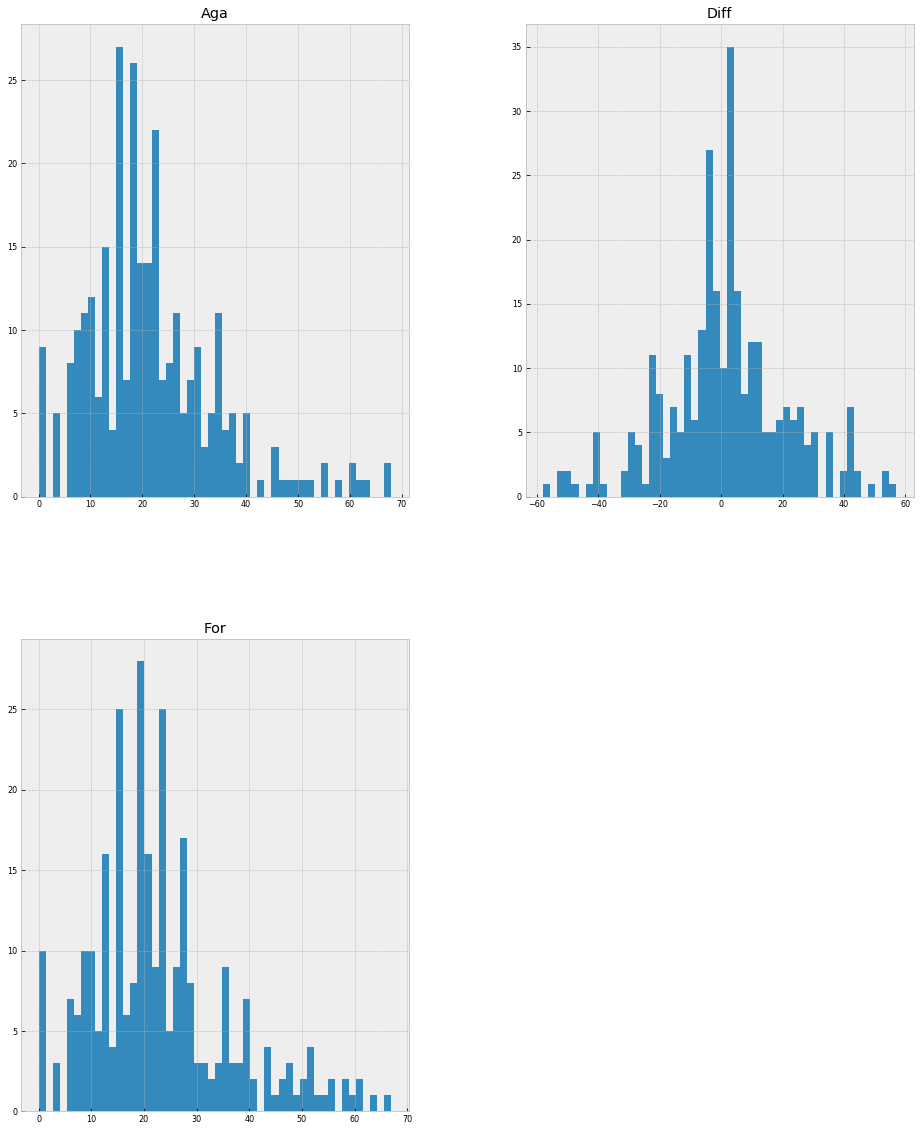

In [192]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

Not much that is not suspected. Score, tries, conversions, penalties all follow a poisson distribution. Diff is normally distributed.

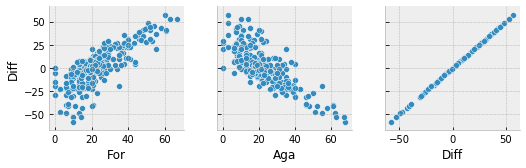

In [193]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['Diff'])

Some scores in rugby are more probable than others given that only 3, 5 and 7 are possible. Here we will examine the number of combinations in which each score (up to 70) can be made. As demonstrated below, the probability does not increase uniformly.

[(0, 1), (1, 0), (2, 0), (3, 1), (4, 0), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 2), (13, 2), (14, 2), (15, 3), (16, 2), (17, 3), (18, 3), (19, 3), (20, 4), (21, 4), (22, 4), (23, 4), (24, 5), (25, 5), (26, 5), (27, 6), (28, 6), (29, 6), (30, 7), (31, 7), (32, 7), (33, 8), (34, 8), (35, 9), (36, 9), (37, 9), (38, 10), (39, 10), (40, 11), (41, 11), (42, 12), (43, 12), (44, 12), (45, 14), (46, 13), (47, 14), (48, 15), (49, 15), (50, 16), (51, 16), (52, 17), (53, 17), (54, 18), (55, 19), (56, 19), (57, 20), (58, 20), (59, 21), (60, 22), (61, 22), (62, 23), (63, 24), (64, 24), (65, 25), (66, 26), (67, 26), (68, 27), (69, 28)]


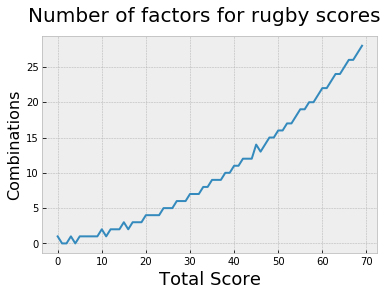

In [194]:
class Combination:
    def combinationSum(self, candidates, target):
        candidates.sort()
        res=[]
        self.DFS(candidates,target,0,res,[])
        return res
 
    def DFS(self,candidates,target,start,res,intermedia):
        if target==0:
            res.append(intermedia)
            return
        for i in range(start,len(candidates)):
            if target<candidates[i]:
                return
            self.DFS(candidates,target-candidates[i],i,res,intermedia+[candidates[i]])
 
test = Combination()
 
combinations = [((i, len(test.combinationSum([3,5,7],i))) )for i in range(70) ]


fig = plt.figure()
plt.plot([i[1] for i in perms])
fig.suptitle('Number of factors for rugby scores', fontsize=20)
plt.xlabel('Total Score', fontsize=18)
plt.ylabel('Combinations', fontsize=16)

print(perms)

Sample mean score is 23.46
Bootstrapped mean score is 23.02


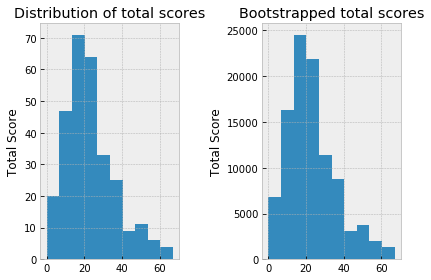

In [195]:
np.random.seed(seed=1234)

boot= np.random.choice(raw_data.For, 100000)

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
 
ax1.hist(raw_data.For)
ax1.set_title("Distribution of total scores")
ax1.set_ylabel("Total Score")

ax2.hist(boot)
ax2.set_title('Bootstrapped total scores')
ax2.set_ylabel('Total Score')

plt.tight_layout()
print("Sample mean score is {:.2f}".format(np.mean(dc1.For)))
print("Bootstrapped mean score is {:.2f}".format(np.mean(boot)))

## Feature engineering 

In [196]:

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290 entries, 0 to 47
Data columns (total 12 columns):
Team          290 non-null object
Result        290 non-null object
For           290 non-null float64
Aga           290 non-null float64
Diff          290 non-null float64
Tries         290 non-null object
Conv          290 non-null object
Pens          290 non-null object
Drop          290 non-null object
Opposition    290 non-null object
Ground        290 non-null object
Match Date    290 non-null object
dtypes: float64(3), object(9)
memory usage: 29.5+ KB


In [197]:
import isoweek
from pandas_summary import DataFrameSummary
dc1 = raw_data

Some features of interest may be 

In [198]:
DataFrameSummary(dc1).summary()

Team       Result      For      Aga     Diff  \
count                 NaN          NaN      290      290      290   
mean                  NaN          NaN  23.0138  21.6241  1.38966   
std                   NaN          NaN  13.1586  12.6223  20.0869   
min                   NaN          NaN        0        0      -58   
25%                   NaN          NaN       15       13       -8   
50%                   NaN          NaN       21       20        2   
75%                   NaN          NaN       28       28       11   
max                   NaN          NaN       67       68       57   
counts                290          290      290      290      290   
uniques                 6            4       56       51       79   
missing                 0            0        0        0        0   
missing_perc           0%           0%       0%       0%       0%   
types         categorical  categorical  numeric  numeric  numeric   

                    Tries         Conv         Pens         Drop   Opposition  \
count                 NaN          NaN          NaN          NaN          NaN   
mean                  NaN          NaN          NaN          NaN          NaN   
std                   NaN          NaN          NaN          NaN          NaN   
min                   NaN          NaN          NaN          NaN          NaN   
25%                   NaN          NaN          NaN          NaN          NaN   
50%                   NaN          NaN          NaN          NaN          NaN   
75%                   NaN          NaN          NaN          NaN          NaN   
max                   NaN          NaN          NaN          NaN          NaN   
counts                290          290          290          290          290   
uniques                19           17           17            6           19   
missing                 0            0            0            0            0   
missing_perc           0%           0%           0%           0%           0%   
types         categorical  categorical  categorical  categorical  categorical   

                   Ground   Match Date  
count                 NaN          NaN  
mean                  NaN          NaN  
std                   NaN          NaN  
min                   NaN          NaN  
25%                   NaN          NaN  
50%                   NaN          NaN  
75%                   NaN          NaN  
max                   NaN          NaN  
counts                290          290  
uniques                54           90  
missing                 0            0  
missing_perc           0%           0%  
types         categorical  categorical

In [199]:
def add_datepart(df, colname):
    dfx = df
    dfx["Date"] = pd.to_datetime(dfx[colname])
    dfx["Year"] = dfx.Date.dt.year
    dfx["Month"] = dfx.Date.dt.month
    dfx["Week"] = dfx.Date.dt.week
    dfx["Day"] = dfx.Date.dt.day
    return dfx 
    

In [214]:
dc1.sort_values(by=['Team','Date']).head()
dc1.sort_values(['Date'], ascending = False).head()


Team Result  For  Aga  Diff Tries Conv Pens Drop     Opposition  \
0  France      -  0.0  0.0   0.0     -    -    -    -  v New Zealand   
0   Italy      -  0.0  0.0   0.0     -    -    -    -        v Japan   
1  France      -  0.0  0.0   0.0     -    -    -    -  v New Zealand   
1   Italy      -  0.0  0.0   0.0     -    -    -    -        v Japan   
2  France      -  0.0  0.0   0.0     -    -    -    -  v New Zealand   

       Ground   Match Date       Date  Year  Month  Week  Day  
0     Dunedin  23 Jun 2018 2018-06-23  2018      6    25   23  
0           -  16 Jun 2018 2018-06-16  2018      6    24   16  
1  Wellington  16 Jun 2018 2018-06-16  2018      6    24   16  
1           -   9 Jun 2018 2018-06-09  2018      6    23    9  
2    Auckland   9 Jun 2018 2018-06-09  2018      6    23    9

In [201]:
#Convert score into ordinal data
def score(result):
    if result =="": return None
    else: return ["lost","draw","won"].index(result) -1 
    
#Want to take Home Game Advantage into account, so create lookup
home = {'England':['Twickenham','Manchester','Newcastle','Leeds', 'Gloucester', 'London','Wembley','Milton Keynes','Exeter'],
        'Scotland':['Murrayfield','Hamilton','Kilmarnock'],
        'Wales': ['Millennium Stadium','Principality Stadium'],
        'Ireland':['Landsdowne Road'],
        'France':['Stade de France','Marseille','Paris','Toulouse'],
        'Italy':['Rome','Firenze','Catania','Padova','Genova','Torino','Ascoli Piceno']}

def isHome(Team, Ground):
    return int(Ground in home[Team])


def shiftRes(df, n=5):
    cols = ['Resultn','For','Aga','Diff','Tries','Conv','Pens','Drop','Opposition','Ground','Year','Month','Day','Home']
    dfx = df.sort_values(by=['Team','Date'])
    for k, v in dfx.groupby('Team'):
        for i in range(1, n+1):
            for res in cols:
                dfx["Prev"+res+str(i)] = dfx[res].shift(i)
    return dfx



In [245]:
def preproc(df):
    dfx = df[df.Result != '-']
    dfx = add_datepart(dfx,"Match Date")
    dfx['Resultn']= dfx.Result.apply(score)
    dfx['Home'] = dfx.apply(lambda row: isHome(row.Team, row.Ground), axis=1)
    dfx['Opposition'] = dfx.Opposition.astype(str).str.split().str[1]
    dfx = dfx.apply(LabelEncoder().fit_transform)
    dfx = shiftRes(dfx)
    dfx = dfx.dropna(axis=0, how='any')
    return dfx
    
#To shift



In [246]:
dc2 = preproc(dc1)
dc2.tail()

/home/karma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/karma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/karma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

Team  Result  For  Aga  Diff  Tries  Conv  Pens  Drop  Opposition  \
4     5       1   17   25    27      6     3     7     1           1   
3     5       2    9    2    42      3     3     5     1           6   
2     5       1   14   29    20      6     3     5     1          10   
1     5       2   20   18    37      8     7     3     1          14   
0     5       2   30    3    61     10     9     5     1          13   

     ...      PrevTries5  PrevConv5  PrevPens5  PrevDrop5  PrevOpposition5  \
4    ...             3.0        3.0        5.0        1.0             13.0   
3    ...             8.0        5.0        3.0        1.0              7.0   
2    ...             1.0        1.0       13.0        1.0              5.0   
1    ...             6.0        1.0        9.0        1.0             15.0   
0    ...             6.0        1.0        7.0        1.0             12.0   

   PrevGround5  PrevYear5  PrevMonth5  PrevDay5  PrevHome5  
4         28.0        3.0         0.0      24.0        0.0  
3         26.0        3.0         1.0       9.0        1.0  
2         42.0        3.0         1.0      17.0        0.0  
1          3.0        3.0         3.0      15.0        0.0  
0          1.0        3.0         3.0      22.0        0.0  

[5 rows x 89 columns]

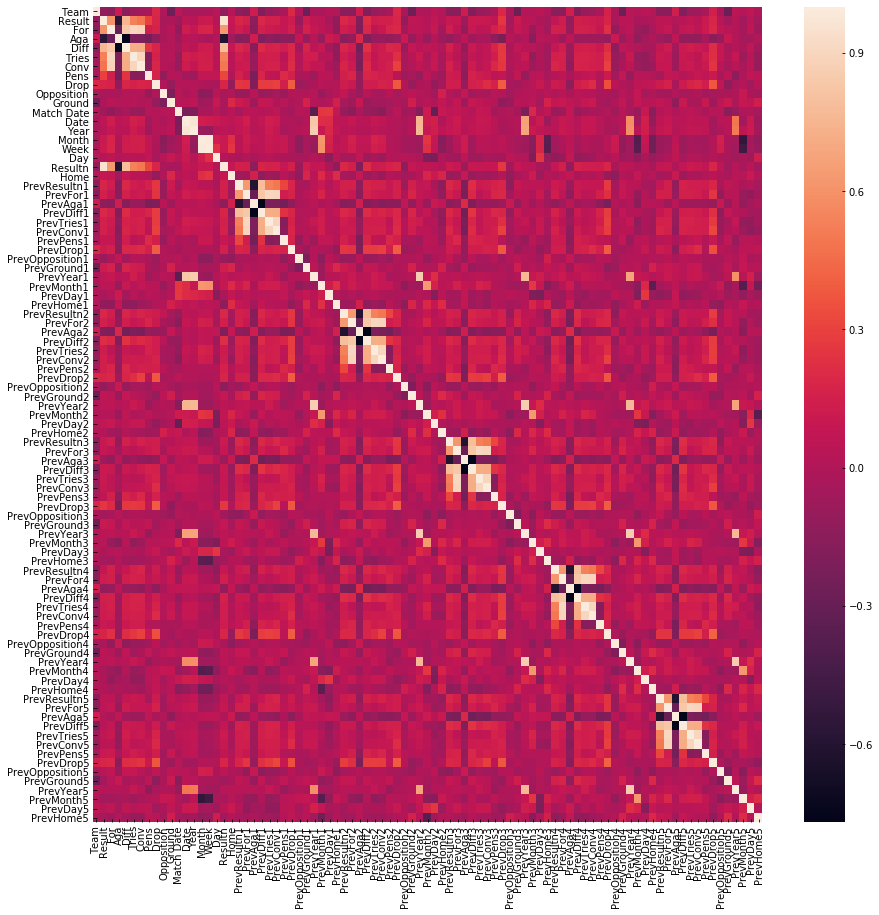

In [254]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,15) )

corr = dc2.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, ax=ax)

In [ ]:
contin_vars = [c+str(i) for i in range(1,6) for c in [
    'PrevResultn',      
    'PrevFor',           
    'PrevAga',           
    'PrevDiff',         
    'PrevTries',         
    'PrevConv',          
    'PrevPens',          
    'PrevDrop',          
    'PrevYear' ,         
    'PrevMonth' ,        
    'PrevDay',
    'PrevHome']]
  
cat_vars = [c+str(i) for i in range(1,6) for c in ['PrevOpposition','PrevGround']]

keep_vars = [
    'Team',
    'Opposition',     
    'Ground',         
    'Match Date',       
    'Date',           
    'Year',        
    'Month',          
    'Week',             
    'Day' ,            
    'Home']

In [ ]:
all_vars = keep_vars + cat_vars + contin_vars 

In [ ]:
import random 
import xgboost as xgb


def split_train_test(df):
#try train/dev/test split of 80/20
    n = len(df)
    dfx = df.sort_values(['Date'])
    train, test = int(.8*n), int(.2*n)
    dfk = dfx[cat_vars+contin_vars+keep_vars]
    test, valid, train = dfk[:test_n], dfk[test_n:val_n], dfk[val_n:]
    y_test, y_valid, y_train  =  dfx.Aga[:test_n], dfx.Aga[test_n:val_n], dfx.Aga[val_n:]
    return (train,y_train), (valid,y_valid), (test, y_test)

xgb_parms = {'learning_rate': 0.1, 'subsample': 0.6, 
             'colsample_bylevel': 0.6, 'silent': True, 'objective': 'reg:linear'}


train_data, valid_data, test_data = split_train_test(dc2)


xdata_train = xgb.DMatrix(train_data[0], train_data[1], feature_names=all_vars)
xdata_valid = xgb.DMatrix(valid_data[0], valid_data[1], feature_names=all_vars)
xgb_parms['seed'] = random.randint(0,1e9)
model_imp = xgb.train(xgb_parms, xdata_train)

In [ ]:

fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model_imp, max_num_features=100, height=0.8, ax=ax)
plt.show()

In [247]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import r2_score
 
dfx = dc2.sort_values(['Date'])

n = int(len(dfx)*.8)
train, test = dfx[:n], dfx[n:]


X_train = train[all_vars]
y_train = train.For
    
    
X_test = test[all_vars]
y_test = test.For    
    


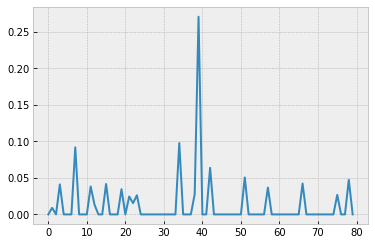

In [250]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor


models = []

models.append(("Elastic Net",ElasticNet(random_state=0)))
models.append(("SVC",SVC()))
models.append(("LinearSVC",LinearSVC()))
models.append(("KNeighbors",KNeighborsClassifier()))
models.append(("RandomForestRegressor",RandomForestRegressor(max_depth=2, random_state=0)))
models.append(("MLPClassifier",MLPClassifier(solver='lbfgs', random_state=0)))


results = []
names = []
for name,model in models:
    result = cross_val_score(model, X_train, y_train,  cv=10)
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

In [ ]:
model = xgb.XGBRegressor()
param_search = {
    # Parameters that we are going to tune.
    'max_depth':[2,4,8,16,32,64]
    'min_child_weight': [.1,1,10],
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
}


In [ ]:
model = xgb.XGBRegressor()
param_search = {'max_depth' : [3, 5]}

my_cv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=my_cv,
                        param_grid=param_search)



In [227]:

#Needed for Xgboost    
xtrain = xgb.DMatrix(X_train, y_train, feature_names=all_vars)    
xtest =xgb.DMatrix(X_test, y_test, feature_names=all_vars)    
xgb_parms = {'learning_rate': 0.1, 'subsample': 0.6, 
             'colsample_bylevel': 0.6, 'silent': True, 'objective': 'reg:linear'}
xgb_parms['seed'] = random.randint(0,1e9)
model = xgb.train(xgb_parms, xtrain)
model.eval(xtest)

'[0]\teval-rmse:14.559711'

In [230]:


model = xgb.XGBRegressor()
param_search = {'max_depth' : [3, 5]}

my_cv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=my_cv,
                        param_grid=param_search)


gsearch.fit(X_train, y_train)


#X = test[all_vars]
#y = test.For
r2 = r2_score( y, gsearch.best_estimator_.predict(X_train))


def adj_r2(r2, nrow, ncol):
    return 1-(((1-r2)*(nrow-1))/(nrow-ncol-1))
    
print("R-squared {:.4f}".format(r2))
print("Adjusted r-squared {:.4f}".format(adj_r2(r2,len(y),len(X.columns))))




R-squared 0.9987
Adjusted r-squared 0.9979


In [244]:

from sklearn.preprocessing import Imputer 
imp = Imputer()
dfy = pd.DataFrame(imp.fit_transform(dfx.values))

#cat_maps = [(o, LabelEncoder()) for o in cat_vars]
#contin_maps = [([o], StandardScaler()) for o in contin_vars]

#cat_mapper = DataFrameMapper(cat_maps)
#cat_map_fit = cat_mapper.fit(dfy)

#contin_mapper = DataFrameMapper(contin_maps)
#contin_map_fit = contin_mapper.fit(dfy)


25365

In [231]:
def my_init(scale):
    return lambda shape, name=None: initializations.uniform(shape, scale=scale, name=name)

def emb_init(shape, name=None): 
    return initializations.uniform(shape, scale=2/(shape[1]+1), name=name)

def get_emb(feat):
    name, c = cat_map_info(feat)
    #c2 = cat_var_dict[name]
    c2 = (c+1)//2
    if c2>50: c2=50
    inp = Input((1,), dtype='int64', name=name+'_in')
    # , W_regularizer=l2(1e-6)
    u = Flatten(name=name+'_flt')(Embedding(c, c2, input_length=1, init=emb_init)(inp))
#     u = Flatten(name=name+'_flt')(Embedding(c, c2, input_length=1)(inp))
    return inp,u


def get_contin(feat):
    name = feat[0][0]
    inp = Input((1,), name=name+'_in')
    return inp, Dense(1, name=name+'_d', init=my_init(1.))(inp)

In [234]:
import keras

embs = [get_emb(feat) for feat in cat_map_fit.features]
#conts = [get_contin(feat) for feat in contin_map_fit.features]
#contin_d = [d for inp,d in conts]
x = merge([emb for inp,emb in embs] + [contin_out], mode='concat')
#x = merge([emb for inp,emb in embs] + contin_d, mode='concat')

x = Dropout(0.02)(x)
x = Dense(1000, activation='relu', init='uniform')(x)
x = Dense(500, activation='relu', init='uniform')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model([inp for inp,emb in embs] + [contin_inp], x)
#model = Model([inp for inp,emb in embs] + [inp for inp,d in conts], x)
model.compile('adam', 'mean_absolute_error')
#model.compile(Adam(), 'mse')

NameError: name 'cat_map_fit' is not defined

In [233]:

model_pkl = get_model_pkl()

NameError: name 'contin_map_fit' is not defined

In [ ]:
dfx.tail()
dc1.sort_values(['Date']).tail()


In [142]:
dc1.info()

next_match = pd.DataFrame([['Scotland',"",None,None,None,None,None,None,None,"v Wales","Principality Stadium","03 Feb 2018"]], columns = dc1.columns)
next_match.head()
dc1 = dc1.append(next_match)

44    0
46    0
44    0
47    0
46    0
Name: Year, dtype: int64

In [102]:
#for measuring training time
from time import time 



def train_regressor(reg, X_train, y_train):

    # Start the clock, train the classifier, then stop the clock
    start = time()
    reg.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(reg, features, target):

    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = reg.predict(features)
    
    end = time()
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    
    return mean_squared_error(target, y_pred),y_pred


def train_predict(reg, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(reg.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_regressor(reg, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    rmse, pred = predict_labels(reg, X_train, y_train)

    print ("RMSE for training set: {:.4f} .".format(rmse))
    
    rmse,pred = predict_labels(reg, X_test, y_test)
    print ("RMSE for test set: {:.4f} .".format(rmse))
    return (y_test, pred)


In [103]:
from xgboost import XGBRegressor# fit model no training data
model = XGBRegressor()
eval_set = [(train, y_train), (valid, y_valid)]
model.fit(train, y_train, eval_metric=["error", "rmse"], eval_set=eval_set, verbose=True)
from sklearn.metrics import make_scorer, mean_squared_error
# calculate the auc score
preds = model.predict(valid)

print('\nMean Square error" ', mean_squared_error(y_valid,preds))


[0]	validation_0-error:-16.5446	validation_0-rmse:18.7223	validation_1-error:-16.8214	validation_1-rmse:19.2091
[1]	validation_0-error:-16.5446	validation_0-rmse:17.363	validation_1-error:-16.8214	validation_1-rmse:17.8053
[2]	validation_0-error:-16.5446	validation_0-rmse:16.1425	validation_1-error:-16.8214	validation_1-rmse:16.4497
[3]	validation_0-error:-16.5446	validation_0-rmse:15.0596	validation_1-error:-16.8214	validation_1-rmse:15.3958
[4]	validation_0-error:-16.5446	validation_0-rmse:14.1169	validation_1-error:-16.8214	validation_1-rmse:14.543
[5]	validation_0-error:-16.5446	validation_0-rmse:13.2524	validation_1-error:-16.8214	validation_1-rmse:13.771
[6]	validation_0-error:-16.5446	validation_0-rmse:12.5351	validation_1-error:-16.8214	validation_1-rmse:13.1733
[7]	validation_0-error:-16.5446	validation_0-rmse:11.8754	validation_1-error:-16.8214	validation_1-rmse:12.6546
[8]	validation_0-error:-16.5446	validation_0-rmse:11.2688	validation_1-error:-16.8214	validation_1-rmse:12.

[73]	validation_0-error:-16.5446	validation_0-rmse:4.24186	validation_1-error:-16.8214	validation_1-rmse:10.9615
[74]	validation_0-error:-16.5446	validation_0-rmse:4.21216	validation_1-error:-16.8214	validation_1-rmse:10.9544
[75]	validation_0-error:-16.5446	validation_0-rmse:4.18507	validation_1-error:-16.8214	validation_1-rmse:10.9476
[76]	validation_0-error:-16.5446	validation_0-rmse:4.13342	validation_1-error:-16.8214	validation_1-rmse:10.9312
[77]	validation_0-error:-16.5446	validation_0-rmse:4.10764	validation_1-error:-16.8214	validation_1-rmse:10.9534
[78]	validation_0-error:-16.5446	validation_0-rmse:4.08103	validation_1-error:-16.8214	validation_1-rmse:10.9477
[79]	validation_0-error:-16.5446	validation_0-rmse:4.05427	validation_1-error:-16.8214	validation_1-rmse:10.9288
[80]	validation_0-error:-16.5446	validation_0-rmse:3.99783	validation_1-error:-16.8214	validation_1-rmse:10.97
[81]	validation_0-error:-16.5446	validation_0-rmse:3.96943	validation_1-error:-16.8214	validation_

In [281]:
pred=model.predict(test.head(1))
print(pred)

[ 15.72047234]


Training a XGBRegressor using a training set size of 224. . .
Trained model in 0.0850 seconds
Made predictions in 0.0020 seconds.
RMSE for training set: 11.0064 .
Made predictions in 0.0011 seconds.
RMSE for test set: 121.4837 .


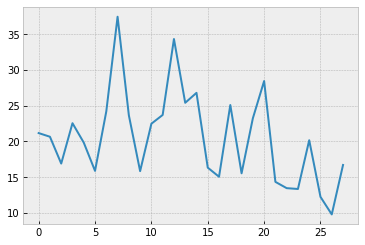

In [105]:
from sklearn import linear_model

# Initialize the three models (XGBoost is initialized later)
reg_A = linear_model.ElasticNet
reg_B = linear_model.BayesianRidge()
#Boosting refers to this general problem of producing a very accurate prediction rule 
#by combining rough and moderately inaccurate rules-of-thumb
reg_C = xgb.XGBRegressor(seed = 82)

#train_predict(reg_A, train, y_train, valid, y_valid)

#train_predict(reg_B, train, y_train, valid, y_valid)

act, pred = train_predict(reg_C, train, y_train, valid, y_valid)
pred[:5]
a = [a for a in act]
plt.plot(pred)